# "공간 변형기 네트워크"
> "Pytorch에서 공간 변형기의 기본 함수인 affine_grid와 grid_sample 함수를 살펴본다."

- toc: true
- badges: true
- author: 단호진
- categories: [pytorch]

## F.affine_grid

* 이미지의 x, y 표준 좌표: $[-1, 1]$
* $\theta$(N x 2 x 3): $\left[ \begin{array}{c} x^s \\ 1 \end{array} \right] = \left[ \begin{array}{cc} \theta & \theta_{\text{translate}} \\ 0 & 1 \end{array} \right] \left[ \begin{array}{c} x^t \\ 1 \end{array} \right]$
    * 좌변이 출발항(source)인 점에 주의
* size N x C x H x W: output image size
* align_corners(default False): pixel은 하나의 점이 아니라 크기를 가지는 면으로 취급된다. 아래 그림에서 x, y는 -0.5에서 시작되는 점을 주목하자. 기본 값인 align_corners=False는 출발과 도착 영상이 있을 때 아래 그림 전체를 정규화한 후 보간 샘플링을 진행한다. 반면 align_corners=True로 설정하면 왼쪽 그림에서 $x \in [0, 6]$, 오른쪽 그림에서 $x \in [0, 2]$의 부분을 맞추고 보간 샘플링을 수행한다. 코드를 직접 짠다면 True의 경우가 더 쉽지만 영상 전체에서 영상 전체로 변형기를 작용시킨다고 할 때 align_corners가 더 직관적이기에 기본 값도 True에서 False로 변경되었다.

## F.grid_sample

* input N x C x Hin x Win: input image

## 참고

1. Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu, Spatial Transformer Networks,  https://arxiv.org/abs/1506.02025
2. Pytorch API docs, torch.nn.functional, https://pytorch.org/docs/stable/nn.functional.html

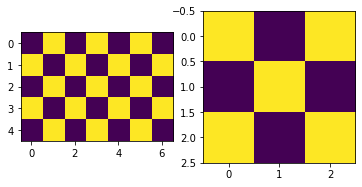

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)

x1 = np.zeros((5, 7))
x2 = np.zeros((3, 3))
x1[0, :] = x1[2, :] = x1[4, :] = np.array([0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0])
x1[1, :] = x1[3, :] = np.array([1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0])
x2[0, :] = x2[2, :] = np.array([1.0, 0.0, 1.0])
x2[1, :] = np.array([0.0, 1.0, 0.0])


axes[0].imshow(x1)
axes[1].imshow(x2)

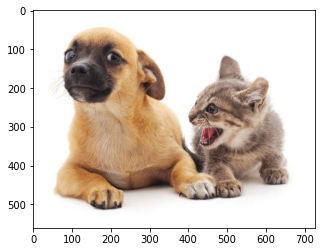

In [54]:
import io
import requests
from PIL import Image

import torch
import torch.nn.functional as F

img = requests.get('https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/catdog.jpg')
img = io.BytesIO(img.content)
img = Image.open(img).convert('RGB')
img = np.array(img)
img = torch.from_numpy(img).float() / 255.0
plt.imshow(img)

In [43]:
img.shape

(561, 728, 3)

In [58]:
theta_translate = lambda t: torch.tensor([[1.0, 0.0, t[0]],
                                          [0.0, 1.0, t[1]]])

def theta_rotate(theta: torch.Tensor):
    c, s = torch.cos(theta), torch.sin(theta)
    return torch.tensor([[c, -s, 0.0], [s, c, 0.0]])

def get_transformed_img(src: torch.Tensor, theta):
    theta = theta.unsqueeze(0)
    src = src.permute(2, 0, 1).unsqueeze(0)
    grid = F.affine_grid(theta, src.shape, align_corners=False)
    return F.grid_sample(src, grid, align_corners=False)

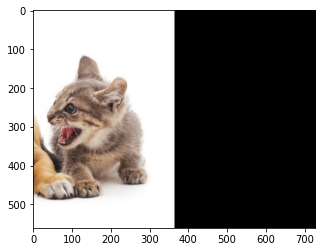

In [57]:
transformed = get_transformed_img(img, theta_translate([1.0, 0.0]))
transformed = transformed.squeeze().permute(1, 2, 0)
plt.imshow(transformed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


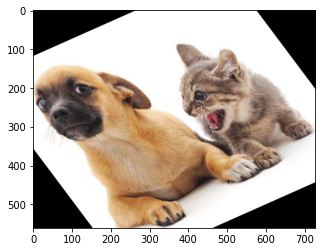

In [60]:
transformed = get_transformed_img(img, theta_rotate(torch.tensor(30.0 * np.pi / 180.0)))
transformed = transformed.squeeze().permute(1, 2, 0)
plt.imshow(transformed)

y+ 방향이 아래쪽을 향하고 있다는 것에 주의하여 회전 행렬을 생각해야 한다.